# Explore here

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import root_mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf





In [2]:


data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")

sales = data.copy()

sales.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [3]:
# Convertimos el indice a formato Datetime

sales['date'] = pd.to_datetime(sales['date'])

sales.set_index('date', inplace = True)

sales.head()

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633


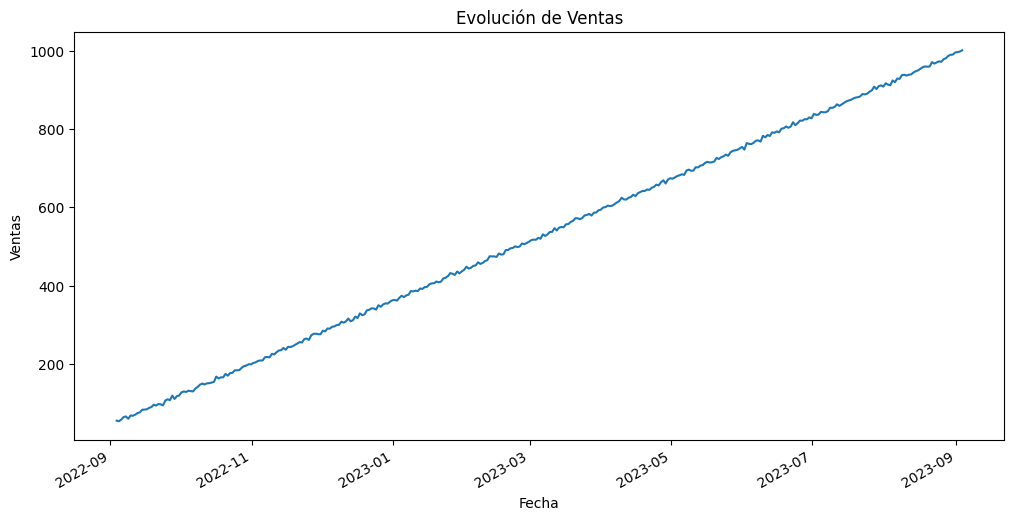

In [4]:

sales['sales'].plot(title="Evolución de Ventas", figsize=(12, 6))
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.show()

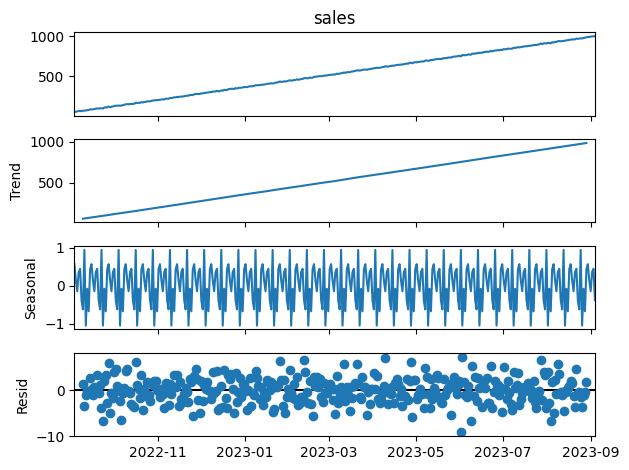

In [5]:
# Descomponemos la serie temporal
result = seasonal_decompose(sales['sales'], model='additive', period=12)
result.plot()
plt.show()

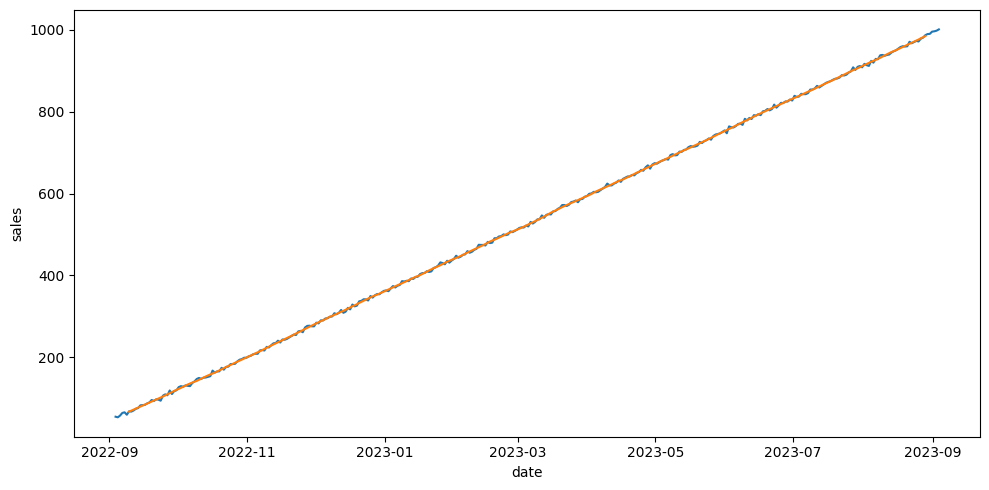

In [33]:
# Analisis de tendencia

tendencia = result.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = sales['sales'])
sns.lineplot(data = tendencia)

plt.tight_layout()

plt.show()

En la gráfica vemos un patrón de crecimiento de las ventas

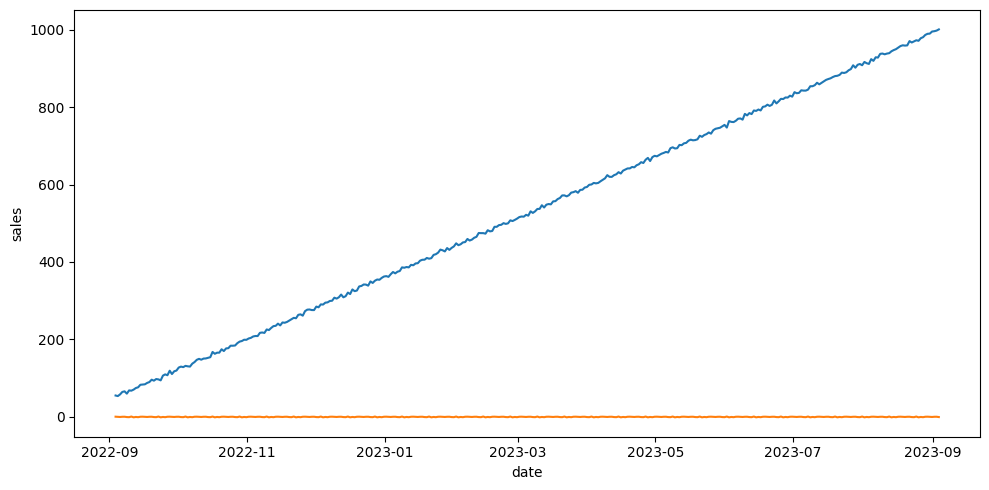

In [34]:
# Analisis de estacionalidad

seasonal = result.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = sales['sales'])
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

Para estudiar la estacionalidad de la serie aplicamos el test de Dickey-Fuller

In [35]:

def test_stationarity(timeseries):
    print("Resultados del test de Dickey Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(sales['sales'])

Resultados del test de Dickey Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Al comprobar que el valor de p es mayor que 0.05, concluimos que la serie no es estacionaria. Que el valor de Test Statistic sea mayor que los valores críticos refuerza la conclusión de que la serie no es estacionaria

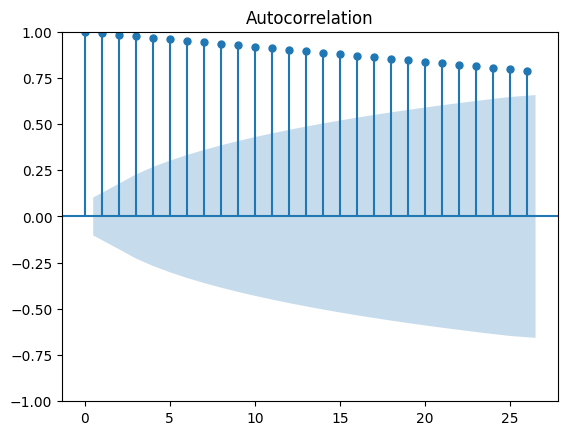

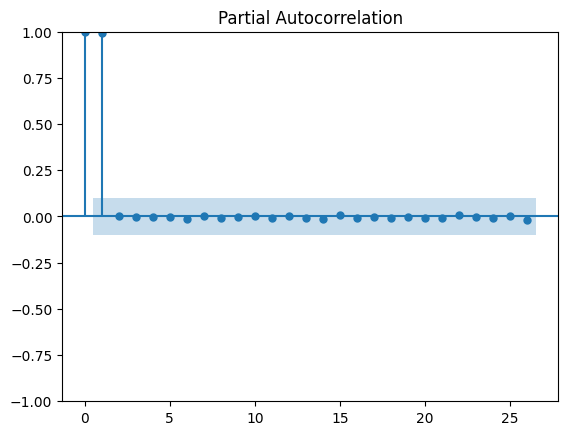

In [7]:

plot_acf(sales['sales'])
plot_pacf(sales['sales'])
plt.show()

De las graficas anteriores podemos sacar los valores de p, d y q para nuestro modelo ARIMA

-p (retardos de la serie): vemos una caída en la gráfica PACF por lo que el valor es 1

-d (diferenciaciones): podemos ver que haría falta un sola difrenciación para que la serie se vuelve estacionaria (p-value<0.05) por lo tanto d = 1

-q (retardos del error): la gráfica ACF no muestra un corte claro, podemos concluir que q = 0

In [8]:

model = ARIMA(sales['sales'], order=(1, 1, 0), )  # Reemplazamos p, d, q con los valores obtenidos
modelo_ventas = model.fit()
print(modelo_ventas.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  366
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1100.941
Date:                Mon, 06 Jan 2025   AIC                           2205.881
Time:                        13:44:33   BIC                           2213.681
Sample:                    09-03-2022   HQIC                          2208.981
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1252      0.067     -1.870      0.061      -0.256       0.006
sigma2        24.4012      1.821     13.398      0.000      20.832      27.971
Ljung-Box (L1) (Q):                  84.27   Jarque-

C:\Users\rmo_l\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rmo_l\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rmo_l\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [20]:

pronostico = modelo_ventas.predict(240)
pronostico

2023-05-01 17:10:08.079328    673.665485
2023-05-02 17:10:08.079328    672.913039
2023-05-03 17:10:08.079328    675.652363
2023-05-04 17:10:08.079328    679.039176
2023-05-05 17:10:08.079328    681.308441
                                 ...    
2023-08-30 17:10:08.079328    988.726453
2023-08-31 17:10:08.079328    989.535411
2023-09-01 17:10:08.079328    994.312833
2023-09-02 17:10:08.079328    995.710857
2023-09-03 17:10:08.079328    997.157920
Freq: D, Name: predicted_mean, Length: 126, dtype: float64

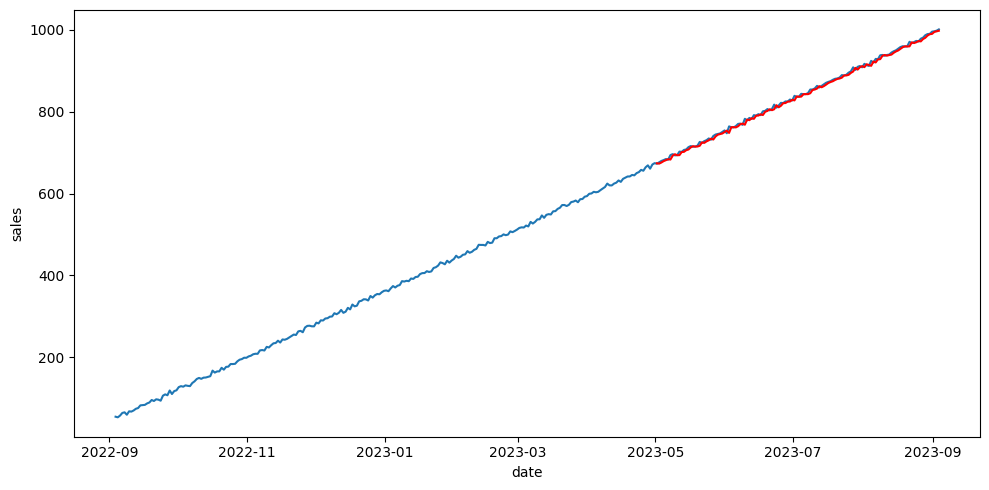

In [22]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = sales['sales'])
sns.lineplot(data = pronostico, c = "red")

plt.tight_layout()

plt.show()